# Imports and custom package

Import necessary packages

In [1]:
import os
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

import matplotlib.pyplot as plt
# keep matplotlib interactive
%matplotlib notebook
# use ggplot style
plt.style.use('ggplot')

# expose the 'utils' directory as one where we can import modules
# here utils is one directory up from notebooks
utils_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(utils_dir)

# import custom package fextract made for this project
from utils import fextract as ft

# Load features and targets

In [2]:
# create relevant directories
features_dir = os.path.join(os.pardir, 'data', 'processed', 'Onehotfeatures.pkl')
target_dir = os.path.join(os.pardir, 'data', 'processed', 'target.npy')

# load features
features = pickle.load( open( features_dir, 'rb' ) )

# load associated targets
y = np.load(target_dir)

Choose features and prepare data for scikit-learn prototyping

In [3]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(features.get(f, 'Feature not present') for f in imp_feature)

In [4]:
X = hstack( X_features )
X.shape, type(X)

((550071, 9996), scipy.sparse.coo.coo_matrix)

# Stacking Ridge and GBRT

Here we will use Ridge and GBRT to predict purchase. From those two outputs, we will make a blender to give us a single purchase prediction. Using Ridge and GBRT is a good choice because there are making different type of mistakes. Stacking both will yield better performance.

Split training set in two parts (One for training Ridge and GBRT and the other to make prediction that will serve as 'clean' features for our blender)

In [5]:
# split training set in two
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=4)

Load Ridge and GRBT models

In [7]:
gbrt_stack = joblib.load('./../models/GBRT_Model.pkl')
ridge_stack = joblib.load('./../models/Ridge_Model.pkl')

Re-train Ridge and GBRT on training data 1st half

In [8]:
ridge_stack.fit(X_1, y_1)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='sag', tol=0.001)

In [9]:
# make sure it starts over (GBRT optimization had warm_start True)
gbrt_stack.warm_start = False
gbrt_stack.fit(X_1, y_1)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1    24759621.8311      367341.3447          209.44m
         2    24435130.9108      356395.5471          200.05m
         3    24125235.9990      346348.1791          196.23m
         4    23744363.2829      341116.7129          194.03m
         5    23407941.0557      335947.3398          192.64m
         6    23126938.0798      327126.4523          191.16m
         7    22735580.5847      323609.8752          190.52m
         8    22410034.5656      316030.0581          189.90m
         9    22098497.4031      310766.9228          189.40m
        10    21826094.4298      301235.9382          188.97m
        20    19024114.0459      249289.7259          189.36m
        30    16791137.8760      201813.8828          187.01m
        40    14897373.5468      166146.0510          185.18m
        50    13414844.8292      134620.0876          185.45m
        60    12110822.4657      110579.9881          184.42m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=925,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=912,
             presort='auto', random_state=29, subsample=0.8, verbose=1,
             warm_start=False)

Save new Ridge and GBRT models

In [11]:
joblib.dump(gbrt_stack, './../models/GBRT_Stack_Model.pkl')
joblib.dump(ridge_stack, './../models/Ridge_Stack_Model.pkl')

['./../models/Ridge_Stack_Model.pkl']

Make predictions on 2nd half

In [12]:
# Ridge and GBRT predictions on 2nd half
gbrt_pred = gbrt_stack.predict(X_2)
ridge_pred = ridge_stack.predict(X_2)
# stack predictions together
X_blender = np.stack((gbrt_pred, ridge_pred), axis=1)

Parameter grid for grid search

In [13]:
# values for parameter grid
alpha_arr = np.array([ 10**x for x in range(-2,1)])
alpha_arr = np.concatenate([alpha_arr, 3*alpha_arr])
# parameter grid
param_grid_model_blr = [ {'alpha': alpha_arr} ]
param_grid_model_blr

[{'alpha': array([ 0.01,  0.1 ,  1.  ,  0.03,  0.3 ,  3.  ])}]

Create Blender (Ridge) and do a grid search

In [14]:
# train blender
model_blr = Ridge( random_state=29, solver='svd')

# polynomial features
# NOTE: no need to do feature scaling since ridge is a closed-form
polystack = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_blender_poly = polystack.fit_transform(X_blender)

# Grid search on max_depth, min_samples_leaf
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
model_blr_grid = GridSearchCV(model_blr, param_grid_model_blr, cv = cv,\
                              scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)

# run grid search
model_blr_grid.fit( X_blender_poly , y_2 )

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=4, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='svd', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'alpha': array([ 0.01,  0.1 ,  1.  ,  0.03,  0.3 ,  3.  ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

Performance result on cross-validation

In [15]:
# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-model_blr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-model_blr_grid.best_score_)) )
print(model_blr_grid.best_estimator_)

MSE, best param, mean cross-val = 6217812.0471
RMSE, best param, mean cross-val = 2493.5541
Ridge(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='svd', tol=0.001)


Performance on entire training set

In [16]:
# metrics on entire dataset, must be higher that Xval scores
y_pred = model_blr_grid.predict(X_blender_poly)

print('\nMSE (whole training set) = {:.4f}'.format(mean_squared_error(y_2, y_pred)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y_2, y_pred))))


MSE (whole training set) = 6220942.7649
RMSE (whole training set) = 2494.1818


### Are mistakes made by GBRT and Ridge really different?
Spoiler alert: yes!

<IPython.core.display.Javascript object>


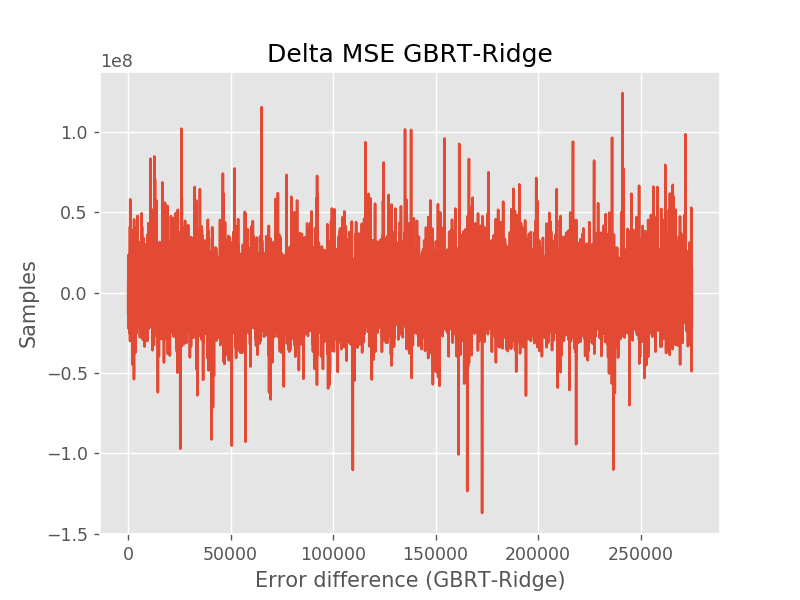

4149929.92484


In [17]:
# plot errors for gbrt and ridge
_, axsterr = plt.subplots()
stack_error = (gbrt_pred-y_2)**2 - (ridge_pred-y_2)**2
axsterr.plot(stack_error)
# add title and axes labels
axsterr.set_title('Delta MSE GBRT-Ridge')
axsterr.set_xlabel('Error difference (GBRT-Ridge)')
axsterr.set_ylabel('Samples')

print(np.std(stack_error))

In [18]:
# try decision tree blender instead of Ridge

# Run model on test set

Read test set in memory, recover encoders from file and derive one-hot encoded features

In [19]:
test_dir = os.path.join(os.pardir, 'data', 'raw','test_HujdGe7', 'test.csv')
df_test = pd.read_csv(test_dir)

# Load encoders
OneHotencoder_dir = os.path.join(os.pardir, 'data', 'Onehotencoders.pkl')
encoders = pickle.load( open( OneHotencoder_dir, 'rb' ) )
Catencoder_dir = os.path.join(os.pardir, 'data', 'Category_encoders.pkl')
catcoders = pickle.load( open( Catencoder_dir, 'rb' ) )

# reload is necessary if one makes changes in fextract. Indeed modules are loaded once only, this forces a reload.
importlib.reload(ft)

# get one-hot encoded features and their names
features_test = ft.prepare_Data(df_test, (catcoders, encoders))

Select necessary features (must match your feature model obviously)

In [20]:
X_features_test = tuple(features_test.get(f, 'Feature not present') for f in imp_feature)
X_test = hstack( X_features_test )
# check shape
X_test.shape

(233599, 9996)

Make predictions and save them to file

In [21]:
gbrt_pred_test = gbrt_stack.predict(X_test)
ridge_pred_test = ridge_stack.predict(X_test)
# stack predictions together
X_blender_test = np.stack((gbrt_pred_test, ridge_pred_test), axis=1)

# get final predictions
X_blender_poly_test = polystack.transform(X_blender_test)
y_pred_test = model_blr_grid.predict(X_blender_poly_test)

# format result save to csv for submission
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
submission_dir = os.path.join(os.pardir,'submissions', 'Submission_Stacking.csv')
df_results.to_csv(submission_dir, index=False)